In [1]:
import os
import math
import datetime
import numpy as np
import pydicom
import SimpleITK as sitk
import matplotlib.pyplot as plt

from collections import defaultdict
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [2]:
# ---------------------------
# 1. Loading the PET Series
# ---------------------------
def load_pet_series(modality_path):
    """
    Load all PET DICOM files from a modality folder, group them by SeriesInstanceUID,
    sort by InstanceNumber, and stack them into a 3D NumPy array.
    
    Parameters:
      modality_path (str): Path to the PET DICOM folder.
    
    Returns:
      dict: Mapping from series UID to a dict containing:
            - 'volume': 3D NumPy array (unsorted raw pixel data)
            - 'metadata': A representative DICOM dataset (from the first slice)
    """
    series_dict = defaultdict(list)
    metadata_dict = {}
    
    for file in os.listdir(modality_path):
        file_path = os.path.join(modality_path, file)
        if os.path.isfile(file_path) and not file.startswith('.'):
            try:
                ds = pydicom.dcmread(file_path)
                series_id = ds.get("SeriesInstanceUID", "UnknownSeries")
                series_dict[series_id].append(ds)
                # Save metadata from the first slice of each series
                if series_id not in metadata_dict:
                    metadata_dict[series_id] = ds
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        # Sort slices by InstanceNumber (or SliceLocation as alternative)
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            volume = np.stack([s.pixel_array for s in ds_list])
            series_volumes[series_id] = {"volume": volume, "metadata": metadata_dict[series_id]}
        except Exception as e:
            print(f"Error stacking slices for series {series_id}: {e}")
    
    return series_volumes


In [3]:
# ---------------------------
# 2. Resampling with SimpleITK
# ---------------------------
def resample_image(itk_image, new_spacing=[1.0, 1.0, 1.0]):
    """
    Resample an ITK image to a new isotropic spacing.
    
    Parameters:
      itk_image (SimpleITK.Image): Input image.
      new_spacing (list): Desired voxel spacing [sx, sy, sz].
      
    Returns:
      SimpleITK.Image: Resampled image.
    """
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    new_size = [int(np.round(osz * ospc / nspc))
                for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetInterpolator(sitk.sitkLinear)
    
    return resample.Execute(itk_image)


In [14]:
# ---------------------------
# 3. SUV Conversion Functions
# ---------------------------
def parse_dicom_time(time_str):
    """
    Parse a DICOM time string in HHMMSS or HHMMSS.FFFFFF format.
    """
    try:
        if '.' in time_str:
            return datetime.datetime.strptime(time_str, "%H%M%S.%f")
        else:
            return datetime.datetime.strptime(time_str, "%H%M%S")
    except Exception as e:
        print(f"Error parsing time '{time_str}': {e}")
        return None

def calculate_decay_correction_factor(series_time, start_time, half_life):
    """
    Calculate the decay correction factor based on the time difference.
    
    Parameters:
      series_time (datetime): Time of series acquisition.
      start_time (datetime): Radiopharmaceutical injection time.
      half_life (float): Half-life in seconds.
      
    Returns:
      float: Decay correction factor.
    """
    delta_t = (series_time - start_time).total_seconds()
    return math.exp(-math.log(2) * delta_t / half_life)

def convert_to_suv(pixel_array, ds):
    """
    Convert raw PET pixel data to SUV values using DICOM metadata.
    
    Required metadata:
      - RescaleSlope and RescaleIntercept
      - RadionuclideTotalDose (Bq)
      - RadionuclideHalfLife (seconds)
      - RadiopharmaceuticalStartDateTime (YYYYMMDDHHMMSS)
      - SeriesTime (HHMMSS[.FFFFFF]) and optionally SeriesDate (YYYYMMDD)
      - PatientWeight (kg; converted to grams)
      
    Parameters:
      pixel_array (np.ndarray): PET image data.
      ds (pydicom.Dataset): Representative DICOM dataset for metadata.
      
    Returns:
      np.ndarray: SUV image.
    """
    print("---- SUV Conversion Debug Info ----")
    
    # Extract conversion factors using the correct keys
    rescale_slope = float(ds.get("RescaleSlope", 1))
    rescale_intercept = float(ds.get("RescaleIntercept", 0))
    total_dose = float(ds.get("RadionuclideTotalDose", 1))  # Use the correct key
    half_life = float(ds.get("RadionuclideHalfLife", 1))
    
    print("Rescale Slope:", rescale_slope)
    print("Rescale Intercept:", rescale_intercept)
    print("Radionuclide Total Dose (Bq):", total_dose)
    print("Radionuclide Half-Life (s):", half_life)
    
    # Use RadiopharmaceuticalStartDateTime if available, otherwise fallback
    if "RadiopharmaceuticalStartDateTime" in ds:
        start_time_str = ds.get("RadiopharmaceuticalStartDateTime")
        # Expecting a string in format YYYYMMDDHHMMSS
        start_time = datetime.datetime.strptime(start_time_str, "%Y%m%d%H%M%S")
    else:
        start_time_str = ds.get("RadiopharmaceuticalStartTime", "000000")
        start_time = parse_dicom_time(start_time_str)
    print("Start Time (used):", start_time)
    
    # For series time, if SeriesDate is provided, combine it; otherwise, use start date.
    if "SeriesDate" in ds:
        series_date_str = ds.get("SeriesDate")
        series_time_str = ds.get("SeriesTime", "000000").split('.')[0]
        series_time = datetime.datetime.strptime(series_date_str + series_time_str, "%Y%m%d%H%M%S")
    else:
        # Use the SeriesTime with the date from start_time
        series_time_str = ds.get("SeriesTime", "000000").split('.')[0]
        parsed_series_time = parse_dicom_time(series_time_str)
        series_time = datetime.datetime.combine(start_time.date(), parsed_series_time.time())
    print("Series Time (used):", series_time)
    
    # Convert patient weight from kg to grams
    patient_weight = float(ds.get("PatientWeight", 1)) * 1000
    print("Patient Weight (g):", patient_weight)
    
    # Calculate decay correction factor
    decay_factor = calculate_decay_correction_factor(series_time, start_time, half_life)
    print("Decay Correction Factor:", decay_factor)
    
    # Convert raw pixel values to activity concentration (Bq/ml)
    activity_concentration = pixel_array * rescale_slope + rescale_intercept
    print("Max activity concentration (Bq/ml):", np.max(activity_concentration))
    
    # Adjust dose using decay correction
    corrected_dose = total_dose * decay_factor
    print("Corrected Dose (Bq):", corrected_dose)
    
    # Compute SUV: (Bq/ml * patient weight [g]) / (corrected dose [Bq])
    suv_image = (activity_concentration * patient_weight) / corrected_dose
    print("Max SUV value calculated:", np.max(suv_image))
    print("------------------------------------")
    
    return suv_image



In [16]:
def minmax_normalize(image, clip_min=0, clip_max=30):
    """
    Clip the image to the [clip_min, clip_max] range and then normalize to [0, 1].

    Parameters:
        image (np.ndarray): The input SUV image.
        clip_min (float): The lower bound for clipping.
        clip_max (float): The upper bound for clipping.

    Returns:
        np.ndarray: The normalized image with values in [0, 1].
    """
    image_clipped = np.clip(image, clip_min, clip_max)
    normalized = (image_clipped - clip_min) / (clip_max - clip_min)
    return normalized


In [8]:
# ---------------------------
# 4. Visualization Functions
# ---------------------------
def visualize_volume_3d(volume, level=None):
    """
    Visualize a 3D volume using the marching cubes algorithm.
    """
    if level is None:
        level = np.mean(volume)
        print(f"No level provided. Using mean intensity: {level:.2f}")
    
    verts, faces, normals, values = measure.marching_cubes(volume, level=level)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.45, 0.45, 0.75])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[2])
    ax.set_title("3D Volume Rendering")
    plt.tight_layout()
    plt.show()

def visualize_slice(volume, slice_index=None, axis=0):
    """
    Visualize a 2D slice from a 3D volume.
    """
    if slice_index is None:
        slice_index = volume.shape[axis] // 2

    if axis == 0:
        slice_data = volume[slice_index, :, :]
    elif axis == 1:
        slice_data = volume[:, slice_index, :]
    elif axis == 2:
        slice_data = volume[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2.")
    
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data, cmap='gray')
    plt.title(f"2D Slice (axis={axis}, index={slice_index})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_mip_axial(volume):
    """
    Generate and display an axial Maximum Intensity Projection (MIP) from a 3D volume.
    (Assumes the volume shape is [slices, rows, columns].)
    """
    # Axial MIP: maximum intensity projection along the slice axis (axis=0)
    axial_mip = np.max(volume, axis=0)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(axial_mip, cmap='gray')
    plt.title("Axial MIP")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Available PET series:
  Series UID: 1.2.840.113619.2.8582.1234.88653339376.1171676 with volume shape: (551, 192, 192)
Resampled volume shape: (276, 96, 96)
---- SUV Conversion Debug Info ----
Rescale Slope: 0.01963811181486
Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 376000000.0
Radionuclide Half-Life (s): 6586.2001953125
Start Time (used): 1976-02-04 09:40:00
Series Time (used): 1976-02-04 10:42:45
Patient Weight (g): 77000.0
Decay Correction Factor: 0.6728469131232998
Max activity concentration (Bq/ml): 643.4820098375176
Corrected Dose (Bq): 252990439.33436072
Max SUV value calculated: 0.19584975182403785
------------------------------------
SUV volume shape: (276, 96, 96)
SUV Statistics:
  Mean SUV: 0.0037135216309482793
  Max SUV: 0.19584975182403785
  Min SUV: 0.0
Normalized SUV Statistics:
  Mean SUV: 0.01896107396799109
  Max SUV: 1.0
  Min SUV: 0.0


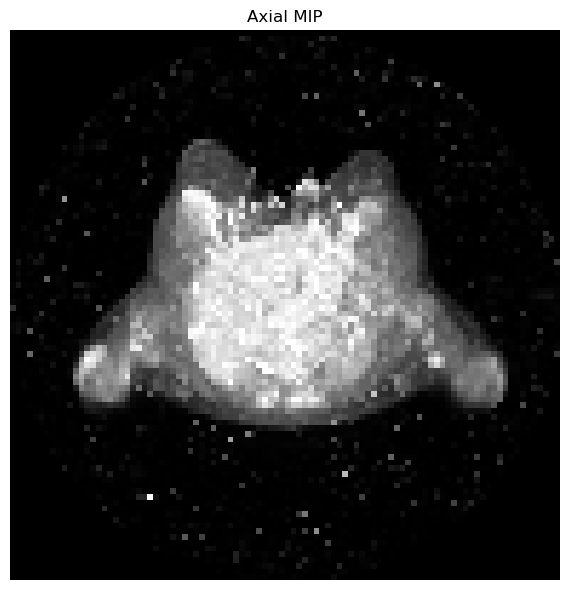

In [18]:

# ---------------------------
# 5. Full PET Preprocessing Pipeline
# ---------------------------
# Specify the path to your PET modality folder.
pet_modality_path = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00001\QClear 550_DICOM"  # <-- update this path

# Load the PET series (grouped by SeriesInstanceUID)
pet_series = load_pet_series(pet_modality_path)
print("Available PET series:")
for series_id in pet_series:
    vol_shape = pet_series[series_id]["volume"].shape
    print(f"  Series UID: {series_id} with volume shape: {vol_shape}")

# For this example, select the first series available.
selected_series_id = list(pet_series.keys())[0]
raw_volume = pet_series[selected_series_id]["volume"]
ref_ds = pet_series[selected_series_id]["metadata"]

# ---------------------------
# Step A: Resample the Volume
# ---------------------------
# Convert the raw NumPy volume to an ITK image.
itk_image = sitk.GetImageFromArray(raw_volume)
# Resample to an isotropic voxel spacing (e.g., 1x1x1 mm).
itk_image_resampled = resample_image(itk_image, new_spacing=[2.0, 2.0, 2.0])
volume_resampled = sitk.GetArrayFromImage(itk_image_resampled)
print("Resampled volume shape:", volume_resampled.shape)

# ---------------------------
# Step B: Convert to SUV
# ---------------------------
suv_volume = convert_to_suv(volume_resampled, ref_ds)
print("SUV volume shape:", suv_volume.shape)

# Assuming suv_volume is your final SUV-converted volume
mean_suv = np.mean(suv_volume)
max_suv = np.max(suv_volume)
min_suv = np.min(suv_volume)

print("SUV Statistics:")
print("  Mean SUV:", mean_suv)
print("  Max SUV:", max_suv)
print("  Min SUV:", min_suv)

# Clip the SUV values to the range 0-30 and normalize to [0, 1]
suv_volume_normalized = minmax_normalize(suv_volume, clip_min=min_suv, clip_max=max_suv)

# Print normalized SUV statistics for verification

mean_norm = np.mean(suv_volume_normalized)
max_norm = np.max(suv_volume_normalized)
min_norm = np.min(suv_volume_normalized)
print("Normalized SUV Statistics:")
print("  Mean SUV:", mean_norm)
print("  Max SUV:", max_norm)
print("  Min SUV:", min_norm)

# (Optional) Discretization or clipping could be added here if needed.
# For example, to clip SUV values between 0 and 30:
#suv_volume = np.clip(suv_volume, 0, 30)

# ---------------------------
# Step C: Generate and Visualize MIP Images
# ---------------------------
visualize_mip_axial(suv_volume_normalized)



In [ ]:
# ---------------------------
# Additional Visualization: 3D and 2D Slices
# ---------------------------
# Visualize a 3D rendering (isosurface extraction)
visualize_volume_3d(suv_volume, level=None)

# Visualize a middle 2D slice along the first axis
visualize_slice(suv_volume, axis=0)